In [1]:
import numpy as np
np.random.seed(42)
import math as mt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import scipy.stats as ss
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# A/B Testing Function
def AB_Test(dataframe, group, target):
    
    # Split A/B
    groupA = dataframe[dataframe[group] == dataframe[group].unique()[0]][target]
    groupB = dataframe[dataframe[group] == dataframe[group].unique()[1]][target]
    
    # Assumption: Normality
    ntA = ss.shapiro(groupA)[1] < 0.05
    ntB = ss.shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = ss.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = ss.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = ss.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = ss.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

<a id='intro'></a>
## Introduction




> **Descriptions:** The data is about an A/B test with a mobile game called "Cookie Cats".

> **Question:** Should we keep using the old version for cookie cats game or release the new version? 



 **Dataset columns descriptions:**

- **userid**: A unique number that identifies each player.
- **version**: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- **sum_gamerounds**: The number of game rounds played by the player during the first 14 days after install.
- **retention_1**: Did the player come back and play 1 day after installing?
- **retention_7**: Did the player come back and play 7 days after installing?

In [3]:
# Let's have a look at our dataset
raw_data = pd.read_csv('cookie_cats.csv')
data = raw_data.copy()
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Number of rows and columns
data.shape

(90189, 5)

In [5]:
# columns data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
# Number of unique values in every column
data.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [7]:
# Convert id column type from int to string
data.userid = data.userid.astype(str)

# Convert version column type from object to category as it has just two unique values to save memory
data.version = data.version.astype('category')

In [8]:
# Number of null values in each column
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [9]:
# Number of duplicated value in data and chec userid for specific
data.duplicated().sum(), data.userid.duplicated().sum()

(0, 0)

In [10]:
# Create retenion column if any convert happen in day 1 or day 7 so it is 1 else 0
data['retention'] = np.where((data.retention_1 == 1) | (data.retention_7 == 1), 1, 0)

In [11]:
# Summary statistic
data.describe()

,sum_gamerounds,retention
count,90189.000000,90189.000000
mean,51.872457,0.485115
std,195.050858,0.499781
min,0.000000,0.000000
25%,5.000000,0.000000
50%,16.000000,0.000000
75%,51.000000,1.000000
max,49854.000000,1.000000


In [12]:
# check if any player install the game and didn't play at all
never_played = data.query('sum_gamerounds == 0')
never_played

,userid,version,sum_gamerounds,retention_1,retention_7,retention
6,1066,gate_30,0,False,False,0
11,2101,gate_30,0,False,False,0
26,3095,gate_30,0,False,False,0
35,4076,gate_40,0,False,False,0
37,4176,gate_30,0,False,False,0
...,...,...,...,...,...,...
90067,9986185,gate_30,0,False,False,0
90093,9988600,gate_40,0,False,False,0
90116,9990773,gate_30,0,False,False,0
90147,9994604,gate_30,0,False,False,0


In [13]:
# Maybe these players are data scientist and have no time to play just open and close
never_played[never_played['retention'] > 0]

,userid,version,sum_gamerounds,retention_1,retention_7,retention
1000,110479,gate_30,0,False,True,1
1872,203165,gate_30,0,True,False,1
2330,257330,gate_30,0,True,False,1
2803,307703,gate_40,0,True,True,1
3994,442819,gate_30,0,True,False,1
...,...,...,...,...,...,...
86779,9616345,gate_40,0,True,False,1
87635,9708844,gate_30,0,True,False,1
87973,9750017,gate_40,0,True,False,1
88671,9830174,gate_40,0,True,False,1


In [14]:
# propotion of never_played to all players
100* never_played.shape[0] / data.shape[0]

4.42847797403231

In [15]:
# Filter data to contain only playes who actually played the game
data = data.iloc[data.query('sum_gamerounds != 0').index]

In [16]:
# New shape of the data
data.shape

(86195, 6)

In [17]:
# Show 'sum_gamerounds' statistics for each version of the game for all players
data.groupby('version')['sum_gamerounds', 'retention'].agg(["count", "median", "mean", "std", "min","max", "sum"])

sum_gamerounds                                                    \
                 count median       mean         std min    max      sum   
version                                                                    
gate_30          42763   18.0  54.832332  262.217984   1  49854  2344795   
gate_40          43432   18.0  53.728357  105.093012   1   2640  2333530   

        retention                                            
            count median      mean       std min max    sum  
version                                                      
gate_30     42763    1.0  0.509880  0.499908   0   1  21804  
gate_40     43432    1.0  0.502786  0.499998   0   1  21837

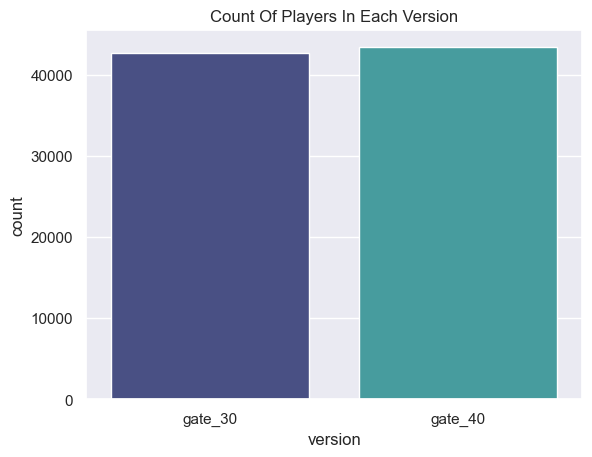

In [18]:
sns.countplot(data= data, x= 'version', palette= 'mako')
plt.title('Count Of Players In Each Version');

In [19]:
# statistics show outliers in sum_gamerounds

# Finding first quartile and third quartile
q1, q3= np.percentile(data['sum_gamerounds'],[25,75])
q1, q3

(6.0, 54.0)

In [20]:
# Find the IQR which is the difference between third and first quartile
iqr = q3 - q1

# Find lower and upper bound
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

lower_bound, upper_bound

(-66.0, 126.0)

In [21]:
# Create dataframe contain heavey players who played more than the upper_bound
heavy_players = data.loc[data['sum_gamerounds'] > upper_bound]
heavy_players.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention
2,377,gate_40,165,True,False,1
4,488,gate_40,179,True,True,1
5,540,gate_40,187,True,True,1
9,1587,gate_40,153,True,False,1
14,2218,gate_30,305,True,True,1


In [22]:
# Show 'sum_gamerounds' statistics for each version of the game for heavy_players
heavy_players.groupby('version')['sum_gamerounds', 'retention'].agg(["count", "median", "mean", "std", "min","max", "sum"])

sum_gamerounds                                                      \
                 count median        mean         std  min    max      sum   
version                                                                      
gate_30           4798  213.0  284.093581  739.825563  127  49854  1363081   
gate_40           4818  211.0  275.501038  193.493471  127   2640  1327364   

        retention                                           
            count median      mean       std min max   sum  
version                                                     
gate_30      4798    1.0  0.976240  0.152316   0   1  4684  
gate_40      4818    1.0  0.975093  0.155857   0   1  4698

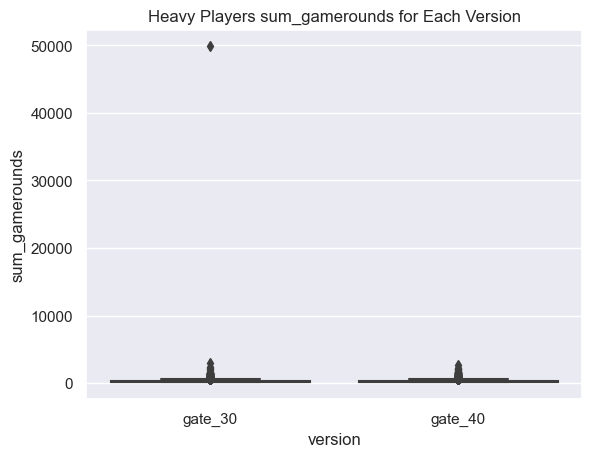

In [23]:
sns.boxplot(data= heavy_players, x= 'version', y= 'sum_gamerounds', palette= 'mako')
plt.title('Heavy Players sum_gamerounds for Each Version');

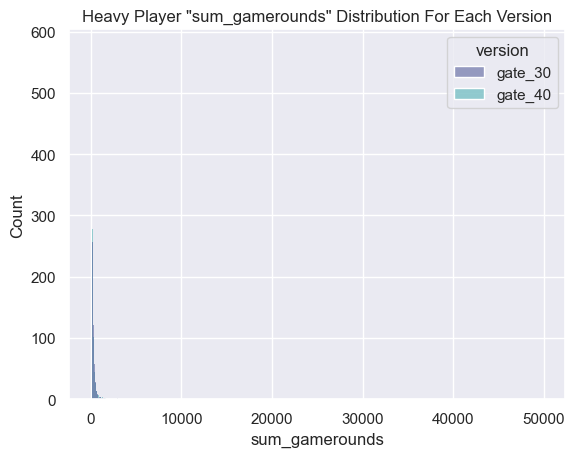

In [24]:
sns.histplot(data= heavy_players, x= 'sum_gamerounds', hue= 'version', palette= 'mako')
plt.title('Heavy Player "sum_gamerounds" Distribution For Each Version');

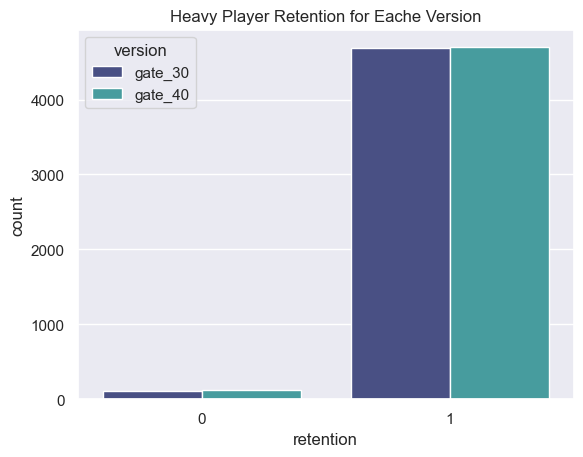

In [25]:
sns.countplot(data= heavy_players, x= 'retention', hue= 'version', palette= 'mako')
plt.title('Heavy Player Retention for Eache Version');

In [26]:
# # Create dataframe contain average players who played less than or equal the upper_bound
average_player = data[~data.index.isin(heavy_players.index)]
average_player.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention
0,116,gate_30,3,False,False,0
1,337,gate_30,38,True,False,1
3,483,gate_40,1,False,False,0
7,1444,gate_40,2,False,False,0
8,1574,gate_40,108,True,True,1


In [27]:
# Show 'sum_gamerounds' statistics for each version of the game for average_player
average_player.groupby('version')['sum_gamerounds', 'retention'].agg(["count", "median", "mean", "std", "min","max", "sum"])

sum_gamerounds                                                 \
                 count median       mean        std min  max      sum   
version                                                                 
gate_30          37965   15.0  25.858396  28.383531   1  126   981714   
gate_40          38614   14.0  26.057026  29.144166   1  126  1006166   

        retention                                            
            count median      mean       std min max    sum  
version                                                      
gate_30     37965    0.0  0.450942  0.497594   0   1  17120  
gate_40     38614    0.0  0.443855  0.496844   0   1  17139

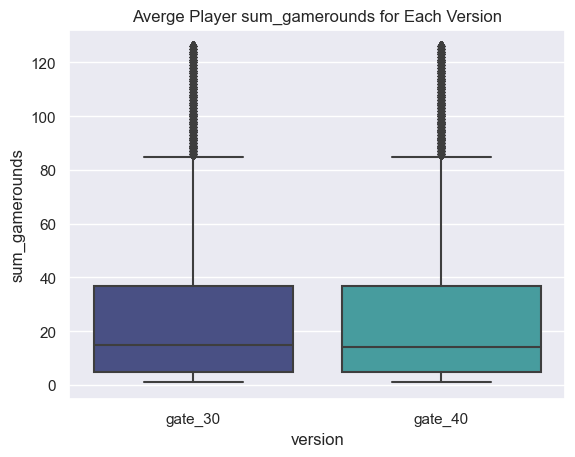

In [28]:
sns.boxplot(data= average_player, x= 'version', y= 'sum_gamerounds', palette= 'mako')
plt.title('Averge Player sum_gamerounds for Each Version');

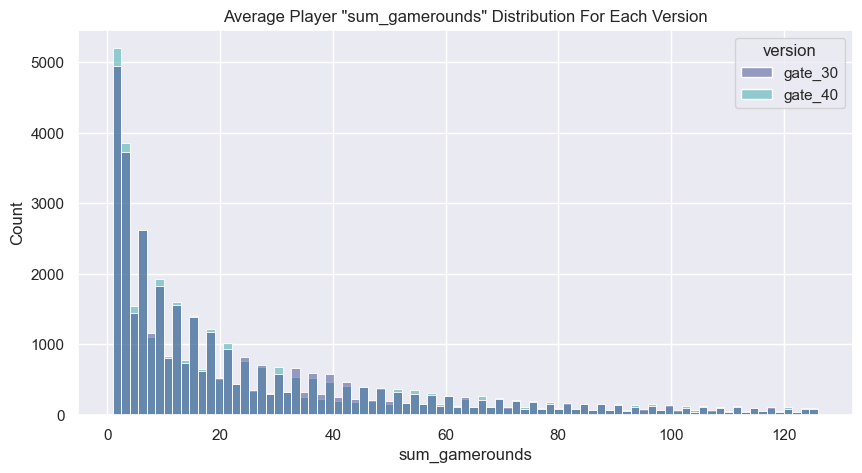

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(data= average_player, x= 'sum_gamerounds', hue= 'version', palette= 'mako')
plt.title('Average Player "sum_gamerounds" Distribution For Each Version');

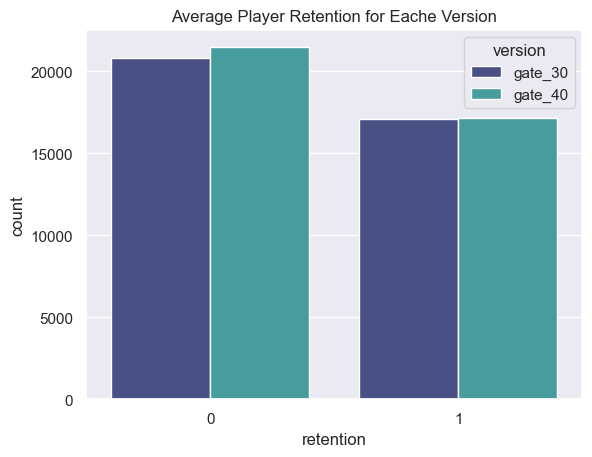

In [30]:
sns.countplot(data= average_player, x= 'retention', hue= 'version', palette= 'mako')
plt.title('Average Player Retention for Eache Version');

# A/B Testing

In [31]:
# Apply A/B Testing for all player for retention
AB_Test(dataframe=data, group = "version", target = "retention")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.037266,A/B groups are not similar!


In [32]:
A = data.query('version == "gate_30"')['retention']
B = data.query('version == "gate_40"')['retention']
ss.mannwhitneyu(A, B, alternative= 'less')

MannwhitneyuResult(statistic=935229156.5, pvalue=0.981367029695632)

**For all player retention gate_30 is better than gate_40**

In [33]:
# Apply A/B Testing for all player for sum_gamerounds
AB_Test(dataframe=data, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.116285,A/B groups are similar!


In [34]:
# Apply A/B Testing for average player for retention
AB_Test(dataframe=average_player, group = "version", target = "retention")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.048601,A/B groups are not similar!


In [35]:
A = average_player.query('version == "gate_30"')['retention']
B = average_player.query('version == "gate_40"')['retention']
ss.mannwhitneyu(A, B, alternative= 'less')

MannwhitneyuResult(statistic=738185027.5, pvalue=0.9756997063213401)

**For Average Player retention gate_30 is better than gate_40**

In [36]:
# Apply A/B Testing for average player for sum_gamerounds
AB_Test(dataframe=average_player, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.137823,A/B groups are similar!


In [37]:
# Apply A/B Testing for heavy player for retention
AB_Test(dataframe=heavy_players, group = "version", target = "retention")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.715222,A/B groups are similar!


In [38]:
# Apply A/B Testing for heavy player for sum_gamerounds
AB_Test(dataframe=heavy_players, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.879724,A/B groups are similar!


# Concolusion
**gate_30 is better than gate_40 For all players and Average Player retention**

**No significant difference All Other Metrics**

- We can go further and test for retention_1 and retention_7 for each group.